In [2]:
import numpy as np
import tensorflow as tf
data = np.loadtxt('Buettner2015Features@1024.csv', delimiter=',', dtype='object')
gene_names = data[0, 1:]
data = data[1:, 1:].astype(np.float32)
data = tf.constant(data)
cov = tf.linalg.matmul(tf.transpose(data), data) / (data.shape[0] - 1)
data = tf.transpose(data)

2022-10-29 21:43:14.320664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-29 21:43:21.497736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
def _generate_random_sample_py(data, k):
    rang = np.arange(data.shape[0])
    return np.asarray([
        np.random.choice(rang, k, replace=False)
        for i in range(8192)
    ])

def generate_random_ensemble(data, k):
    result = tf.py_function(
        _generate_random_sample_py,
        [data, k],
        tf.int32)
    return tf.ensure_shape(result, [8192, k])

In [3]:
import tensorflow_probability as tfp

@tf.function(jit_compile = True)
def transpose_simple(matrices):
    """Transpose utility for batches of matrices (high-dimensional)."""
    ndim = len(matrices.shape)
    return tf.transpose(matrices, list(range(ndim-2)) + [ndim-1, ndim-2])

@tf.function(jit_compile = True)
def create_block_diagonal_augmented_u(svd_u):
    """Treat the batch of u matrices as being updated block diagonally.

    The orthonormal basis is trivial on the left side at this point, when
    adding a new row. The existing basis is zero along this dimension, and
    we produce an orthonormal basis vector e_N. Then, the augmented matrix
    SVD would need a V with a more sophisticated basis vector, but we
    discard V in this algorithm.
    
    The new SVD factorization's left singular vectors are found by
    multiplying this trivial matrix by the left singular vectors of the
    "augmented S".
    """
    augmented_pca_u = tf.concat(
        [
            tf.concat(
                [
                    svd_u,
                    tf.zeros(svd_u.shape[:-1] + (1,)),
                ],
                axis=-1,
            ),
            tf.concat(
                [
                    tf.zeros(svd_u.shape[:-2] + (1, svd_u.shape[-1])),
                    tf.ones(svd_u.shape[:-2] + (1, 1)),
                ],
                axis=-1,
            ),
        ],
        axis=-2,
    )
    return augmented_pca_u

@tf.function(jit_compile = True)
def build_update_s_matrix_blocks(svd_s, svd_u, svd_v, possible_rows):
    # Add a row to the SVD decomposition by adding to S*V^T:
    # encoding^T * V + ortho_norm * orthogonalize(V, row)
    # encoding is the vector of the projection of row onto each
    # basis vector in V. The orthogonalize function would subtract
    # the projection onto this column space from row, then save the
    # norm of the resulting normalized vector. The norm goes into S.
    # U is updated with a 1 (add a diagonal block for the identity matrix 1x1).
    # This is the transpose of the single-column update given by Ross 2008.
    # Ross, D. A., Lim, J., Lin, R. S., & Yang, M. H. (2008). Incremental learning for robust visual tracking. International journal of computer vision, 77(1), 125-141.
    n_matrices = svd_s.shape[0]
    n_observations = svd_v.shape[1]
    n_outputs = possible_rows.shape[0]
    feature_k = svd_s.shape[1]
    s_21 = tf.linalg.matmul(possible_rows[None, :, :], svd_v)[:, :, None, :]
    proj_rows_batch_shape = [n_matrices, n_outputs, 1, feature_k]
    transpose_v_batch_shape = [n_matrices, n_outputs, feature_k, n_observations]
    # Note: A projection matrix onto the right-singular vectors is:
    # `svd_v * svd_v^T` (unlike NumPy, "v" return value is not transposed).
    # svd_v contains precisely the eigenvectors of M^T M in columns. We
    # transpose the entire expression projecting our input vectors (which are
    # row vectors). Then, we use the already-computed s_21 and possible_rows.
    # `svd_v * svd_v^T * ColVecs = (RowVecs * svd_v * svd_v^T)^T`
    row_projection = tf.squeeze(
        tf.linalg.matmul(
            s_21,
            transpose_simple(svd_v)[:, None, :, :]),
        axis=2)
    row_ortho = possible_rows[None, :, :] - row_projection
    # row_ortho would be used as a new right-singular vector in V, but we are
    # discarding V. It must be unit-scaled.
    row_ortho = tf.linalg.normalize(row_ortho)[0]
    # Now find the extent of the original data along the orthogonal basis vector.
    s_22 = tf.linalg.matmul(row_ortho[:, :, None, :], possible_rows[None, :, :, None])
    # matmul creates 1x1 matrices, so we extract the scalar value.
    s_22 = s_22[:, :, 0, 0]
    return s_21, s_22

@tf.function(jit_compile = True)
def approximate_update_eigenvalues(svd_s, s_22):
    """Initialization for augmented matrix power iteration.
    
    Augmented S is no longer a diagonal matrix, so the eigenvalues
    are perturbed from the original matrix. Generally, the update
    to the matrix trace is small, and the final eigenvalue is even
    smaller than the final diagonal entry that we append. We can
    divide up the final value of S^2 arbitrarily, and add some of
    that contribution uniformly to the larger eigenvalues, while the
    final eigenvalue will be very small.
    """
    feature_k = svd_s.shape[1]
    aug_contribution = tf.square(s_22) / 2. / feature_k
    return tf.concat([tf.square(svd_s)[:, None, :] + aug_contribution[:, :, None], (tf.square(s_22) / 2.)[:, :, None]], axis=-1)

# TODO: We are close to not needing to create these augmented matrices explicitly.
@tf.function(jit_compile = True)
def build_augmented_s(svd_s, s_21, s_22):
    """Augment S for k+1 rows - no longer a diagonal matrix."""
    b1 = s_21.shape[0]
    b2 = s_21.shape[1]
    feature_k = svd_s.shape[1]
    return tf.concat(
        [
            tf.concat(
                [
                    tf.broadcast_to(
                        tf.linalg.diag(svd_s)[:, None, :, :],
                        [b1, b2, feature_k, feature_k]),
                    tf.zeros((b1, b2, feature_k, 1)),
                ],
                axis=-1,
            ),
            tf.concat(
                [
                    s_21,
                    s_22[:, :, None, None],
                ],
                axis=-1
            ),
        ],
        axis=-2,
    )

@tf.function(jit_compile = True)
def build_augmented_psd(svd_s, s_21, s_22):
    """Build AugS * AugS^T."""
    b1 = s_21.shape[0]
    b2 = s_21.shape[1]
    feature_k = svd_s.shape[1]
    return tf.concat(
        [
            tf.concat(
                [
                    tf.broadcast_to(
                        tf.linalg.diag(tf.square(svd_s))[:, None, :, :],
                        [b1, b2, feature_k, feature_k]),
                    transpose_simple(s_21 * svd_s[:, None, None, :]),
                ],
                axis=-1,
            ),
            tf.concat(
                [
                    s_21 * svd_s[:, None, None, :],
                    tf.square(s_22)[:, :, None, None],
                ],
                axis=-1
            ),
        ],
        axis=-2,
    )

@tf.function(jit_compile = True)
def approximate_eigen0_power_iteration(svd_s, s_21, s_22, niter=3):
    """Power iteration algorithm for a blocked Cholesky matrix.
    
    AugS is represented by [[svd_s, 0], [s_21, s_22]], so we can derive
    AugS * AugS^T and search for its largest eigenvalue. This is initialized
    from the first column of AugS * AugS^T, which has large values in it
    (initial guess).
    """
    b1 = s_21.shape[0]
    b2 = s_21.shape[1]
    feature_k = s_21.shape[-1]
    ev = tf.concat(
        [
            tf.broadcast_to(
                svd_s[:, None, 0:1],
                [b1, b2, 1]),
            tf.zeros((b1, b2, feature_k - 1)),
            svd_s[:, None, 0:1] * s_21[:, :, 0, 0:1],
        ],
        axis=-1,
    )
    ev = ev[:, :, :, None]
    ev = tf.linalg.normalize(ev)[0]
    ev_lambda = None
    # TODO: Benchmark multiplying each block manually, no new
    # matrix creation here.
    psd_matrix = build_augmented_psd(svd_s, s_21, s_22)
    for i in range(niter):
        ev = tf.linalg.matmul(psd_matrix, ev)
        ev, ev_lambda = tf.linalg.normalize(ev, axis=2)
    return ev, ev_lambda[:, :, 0, 0]

@tf.function(jit_compile = True)
def approximate_eigenvalue_power_iteration(svd_s, s_21, s_22, eigenvectors):
    """Single-iteration power iteration for multiple eigenvalues.

    The largest eigenvalue should use a for-loop power iteration for fidelity.
    Here, we apply the matrix once and project back onto the best-guess eigenvector
    (avoiding the eigenvector of the largest and smallest eigenvalues). The
    smallest eigenvalue/eigenvector is not useful to us.
    """
    b1 = s_21.shape[0]
    b2 = s_21.shape[1]
    feature_k = s_21.shape[-1]
    augmented_s = build_augmented_s(svd_s, s_21, s_22)
    augmented_psd = tf.linalg.matmul(augmented_s, transpose_simple(augmented_s))
    result = tf.linalg.matmul(augmented_psd, eigenvectors)
    eigenvectors = tfp.math.gram_schmidt(result)
    result = tf.linalg.matmul(augmented_psd, eigenvectors)
    def norm_power_result(eig_index):
        indexed_eigenvectors = eigenvectors[:, :, :, eig_index:eig_index + 1]
        def make_projection_matrix():
            return tf.linalg.matmul(indexed_eigenvectors, transpose_simple(indexed_eigenvectors))
        def make_identity_matrix():
            return tf.broadcast_to(
                tf.linalg.eye(feature_k + 1)[None, None, :, :],
                [b1, b2, feature_k + 1, feature_k + 1])
        # TODO: Already added separate function for eigen0 so remove tf.cond.
        result_projection = tf.linalg.matmul(
            tf.cond(
                tf.greater(eig_index, 0),
                make_projection_matrix,
                make_identity_matrix),
            result[:, :, :, eig_index:eig_index + 1])
        result_projection = result_projection[:, :, :, 0]
        return tf.linalg.norm(result_projection, axis=2)
    # These skip the lambda0 which should use repeated power iteration.
    # lambda0 greatly affects the Gram Schmidt process so it needs to be high quality.
    # Also, we guess that eigenvector using the first column of AugS*AugS^T.
    eigenvalues = tf.map_fn(
        norm_power_result,
        tf.range(1, eigenvectors.shape[-1]),
        fn_output_signature=tf.float32,
    )
    eigenvalues = tf.transpose(eigenvalues, [1, 2, 0])
    eigenvalues = tf.concat(
        [
            approximate_eigen0_power_iteration(svd_s, s_21, s_22)[1][:, :, None],
            eigenvalues,
        ],
        axis=2
    )
    trace_original = tf.math.reduce_sum(tf.square(svd_s), axis=-1)[:, None]
    trace_aug_missing_final = tf.math.reduce_sum(eigenvalues, axis=-1)
    final_eigenvalue = trace_original + tf.square(s_22) - trace_aug_missing_final
    return tf.concat(
        [
            eigenvalues,
            final_eigenvalue[:, :, None],
        ],
        axis=-1
    )

# TODO: Can we use a Cholesky-like (svd_s - sqrt(lambda) I) * (svd_s - sqrt(lambda) I)^T?
# Write a more typical solver for this.
@tf.function(jit_compile = True)
def solve_update_s_factorization_iteration(svd_s, s_21, s_22, eig):
    """Block Cholesky eigenvector solver for a sparse matrix.
    
    This solution works because all rows but the last row of `AugS * AugS^T`
    have only the diagonal entry and last column which are strictly non-zero.
    
    We want an SVD factorization of AugS so that we end up with the factors
    of an orthonormal U and a diagonal S (V will be discarded). Equivalently,
    we want the eigenvalues and eigenvectors of `AugS * AugS^T`. For the rows
    of `AugS * AugS^T` to be solvable for the eigenvector, then covariance in
    the data matrices should generally be nonzero so that every eigenvalue is
    perturbed.
    
    Suppose `AugS * AugS^T * v = lambda * v`, and `v[-1] = 1`. We compute the
    diagonal and last entry of `AugS * AugS^T` for this row. lambda_i may be
    very close to `(AugS * AugS^T)[i, i]`, so that row is ignored in the solver.
    ev_i is solved using the last row of the matrix, after all other entries
    are solved.
    """
    feature_k = svd_s.shape[1]

    # We will create orthonormal matrices, with eigenvectors in columns. The
    # shape is updated to (b1, b2, feature_k, feature_k - 1). This solver
    # breaks down when it comes to the final (generally smallest) eigenvalue.
    diag_entry = tf.square(svd_s[:, None, :, None]) - eig[:, :, None, :-1]
    # The last column comes from the product of the original s diagonal and the
    # appended row s_21.
    final_entry = svd_s[:, None, :] * s_21[:, :, 0, :]

    def solve_ev(eig_index):
        entries_before = final_entry[:, :, :eig_index] / diag_entry[:, :, :eig_index, eig_index]
        entries_after = final_entry[:, :, eig_index + 1:] / diag_entry[:, :, eig_index + 1:, eig_index]
        this_entry = (
                tf.math.reduce_sum(
                    final_entry[:, :, :eig_index] * entries_before,
                    axis=-1)
                + tf.math.reduce_sum(
                    final_entry[:, :, eig_index + 1:] * entries_after,
                    axis=-1)
                + (tf.square(s_22) - eig[:, :, eig_index]) * 1.
            )[:, :, None] / -final_entry[:, :, eig_index:eig_index + 1]
        return tf.concat(
            [
                entries_before,
                this_entry,
                entries_after,
                tf.ones_like(this_entry),
            ],
            axis=-1
        )

    eigenvectors = tf.concat(
        #[approximate_eigen0_power_iteration(svd_s, s_21, s_22)[0]]
        #+
        [
            solve_ev(eig_index)[:, :, :, None]
            for eig_index in range(int(feature_k))
        ],
        axis=3,
    )
    return tfp.math.gram_schmidt(eigenvectors)

In [6]:
@tf.function
def evaluate_features_batch(data, k, ndim, feature_inds=None):
    if feature_inds is None:
        feature_inds = generate_random_ensemble(data, k)
    matrices = tf.gather(data, feature_inds)
    s, u, v = tf.linalg.svd(matrices)
    s_21, s_22 = build_update_s_matrix_blocks(s, u, v, data[:200])

    ev_rotate = solve_update_s_factorization_iteration(
        s, s_21, s_22, approximate_update_eigenvalues(s, s_22))
    ev_lambda = approximate_eigenvalue_power_iteration(s, s_21, s_22, ev_rotate)
    ev_rotate = solve_update_s_factorization_iteration(s, s_21, s_22, ev_lambda)
    # The eigenvectors of the updated triangular matrix are a rotation of the eigenvectors
    # of the original svd. u simply needs to be updated with a 1 on the diagonal; this is
    # the orthogonal basis that we are using for k+1.
    augmented_pca_u = tf.concat(
        [
            tf.concat(
                [
                    u,
                    tf.zeros(u.shape[:-1] + (1,)),
                ],
                axis=-1,
            ),
            tf.concat(
                [
                    tf.zeros(u.shape[:-2] + (1, u.shape[-1])),
                    tf.ones_like(u)[..., 0:1, 0:1],
                ],
                axis=-1,
            ),
        ],
        axis=-2,
    )
    ev = tf.linalg.matmul(augmented_pca_u[:, None, :, :], ev_rotate)

    feature_performance = tf.linalg.norm(
        ev[:, :, :, :ndim], axis=3,
    )
    feature_score = feature_performance[:, :, -1] - tf.math.reduce_min(feature_performance[:, :, :-1], axis=2)

    data_conflict = tf.reduce_any(
        tf.range(200)[None, :, None] == feature_inds[:, None, :],
        axis=2,
    )
    data_selected = tf.where(data_conflict, tf.constant(np.nan), feature_score)
    return data_selected

In [652]:
%%time
scores = evaluate_features_batch(data, 12, 1)
scores.shape

CPU times: user 1min 56s, sys: 22.1 s, total: 2min 19s
Wall time: 1min 53s


TensorShape([8192, 200])

In [653]:
import matplotlib.pyplot as plt

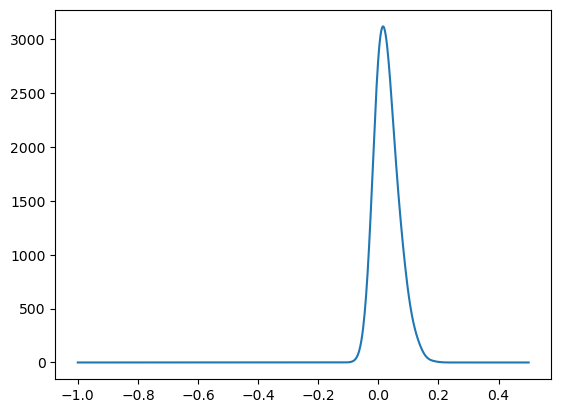

In [667]:
data_index = 185
samp = scores[:, data_index][np.isfinite(scores[:, data_index])]
w = 0.015
xs = np.linspace(-1, 0.5, 600)[None, :]
ys = (
    np.exp(-(xs - samp[:, None]) ** 2 / 2 / w ** 2)
).sum(axis=0)
norm_d1 = ys
plt.plot(xs[0, :], ys)

/var/folders/_7/nzfm900d60v07y_zrq435hdr0000gn/T/ipykernel_67953/741822967.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(xs[0, :], np.sqrt(-np.log(ys) + 10))


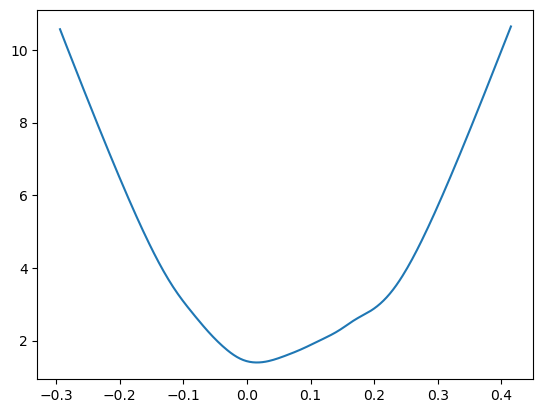

In [659]:
plt.plot(xs[0, :], np.sqrt(-np.log(ys) + 10))

In [660]:
xs[0, np.argmax(ys)]

0.016694490818029983

In [661]:
np.sqrt(
    (ys[:np.argmax(ys)] * (xs[0, :np.argmax(ys)] - xs[0, np.argmax(ys)]) ** 2).sum() / ys[:np.argmax(ys)].sum())

0.03180016732985508

In [662]:
import scipy.stats
scipy.stats.distributions.norm.fit(samp)

(0.028303834, 0.038233783)

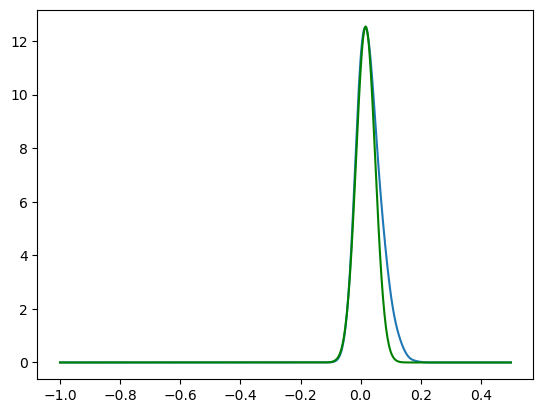

In [676]:
data_index = 185
samp = scores[:, data_index][np.isfinite(scores[:, data_index])]
w = 0.015
xs = np.linspace(-1, 0.5, 600)[None, :]
ys = (
    np.exp(-(xs - samp[:, None]) ** 2 / 2 / w ** 2)
).mean(axis=0) / w / np.sqrt(2 * np.pi) * 1.22
plt.plot(xs[0, :], ys)
plt.plot(xs[0, :], scipy.stats.distributions.norm(loc=0.016694490818029983, scale=0.0318).pdf(xs[0, :]), 'green')

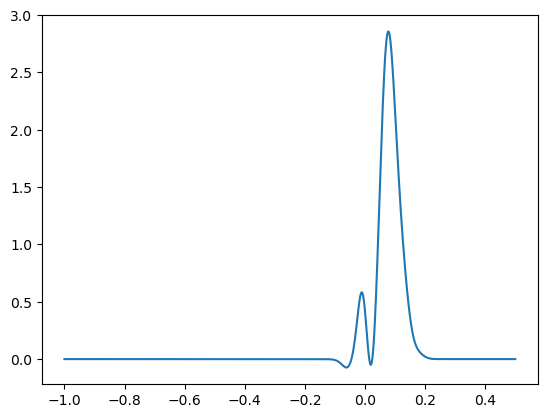

In [682]:
plt.plot(xs[0, :], (y2 := ys - scipy.stats.distributions.norm(loc=0.016694490818029983, scale=0.0318).pdf(xs[0, :])))

/var/folders/_7/nzfm900d60v07y_zrq435hdr0000gn/T/ipykernel_67953/2516856576.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(xs[0, :], np.sqrt(-np.log(y2) + 3))


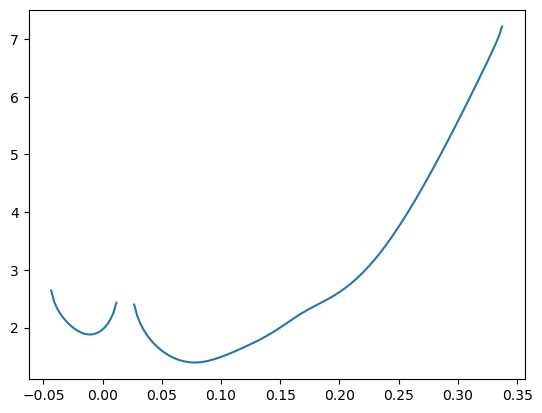

In [686]:
plt.plot(xs[0, :], np.sqrt(-np.log(y2) + 3))

In [61]:
samp = np.sort(samp)

In [601]:
mu1 = tf.Variable(-.3314, name='mu1')
sigma1 = tf.Variable(.05019, name='sigma1')
theta = tf.Variable(0.1, name='theta')
mu2 = tf.Variable(-0.19, name='mu2')
sigma2 = tf.Variable(0.1, name='sigma2')
opt = tf.keras.optimizers.Adam(0.005)

In [638]:
with tf.GradientTape() as tape:
    cdf = (
        tf.math.cos(theta)
        * (1 + tf.math.erf((samp - mu1) / sigma1 / tf.math.sqrt(2.))) / 2.
        + tf.math.sin(theta)
        * (1 + tf.math.erf((samp - mu2) / sigma2 / tf.math.sqrt(2.))) / 2.
    )
    result = tf.math.reduce_sum(tf.math.abs(cdf - tf.linspace(0., 1., samp.shape[0])))

In [639]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=274.21094>

In [640]:
gr = tape.gradient(result, [mu1, sigma1, mu2, sigma2, theta])
gr

[<tf.Tensor: shape=(), dtype=float32, numpy=20117.97>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3638.6118>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-20.703411>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-301.89044>,
 <tf.Tensor: shape=(), dtype=float32, numpy=357.6851>]

mu1.assign_sub(result / gr[0] * 0.1)
sigma1.assign_sub(result / gr[1] * 0.1)
mu2.assign_sub(result / gr[2] * 0.1)
sigma2.assign_sub(result / gr[3] * 0.1)
theta.assign_sub(result / gr[4] * 0.1)
mu1.numpy(), sigma1.numpy(), mu2.numpy(), sigma2.numpy(), theta.numpy()

In [641]:
opt.apply_gradients(zip(gr, [mu1, sigma1, mu2, sigma2, theta]))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=10>

In [ ]:
def mixture_model(samples, niter):
    mu0 = tf.quantile(samples, 0.5, axis=0)[None, :]
    lower = tf.quantile(samples, 0.4, axis=0)[None, :]
    upper = tf.quantile(samples, 0.6, axis=0)[None, :]
    sgn = tf.where(upper - mu0 > mu0 - lower, 1, -1)
    param = tf.concat(
        [
            tf.quantile(samples, 0.5, axis=0)[None, :],
            tf.fill([])
        ])

In [650]:
import tensorflow_probability as tfp
tfp.stats.stddev([1., 3., 5., np.nan])

<tf.Tensor: shape=(), dtype=float32, numpy=nan>